# 画像の欠損補間

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline
%load_ext autoreload
%autoreload 1

plt.rcParams["font.family"] = "IPAexGothic"

import warnings
warnings.filterwarnings('ignore')


Bad key ""backend" on line 1 in
/Users/masui/.matplotlib/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


## 欠損画像を作成

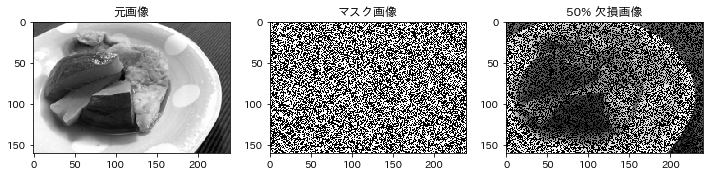

In [2]:
deficit_rate = 0.5
img = np.asarray(Image.open("img/recipe.jpg").convert('L').resize((240, 160)))
mask = (np.random.rand(img.shape[0], img.shape[1]) > deficit_rate)
deficit_img = mask * img

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('元画像')

plt.subplot(1, 3, 2)
plt.imshow(mask, cmap='gray')
plt.title('マスク画像')

plt.subplot(1, 3, 3)
plt.imshow(deficit_img, cmap='gray')
plt.title('{0:.0f}% 欠損画像'.format(deficit_rate * 100))
plt.savefig("./img/result/deficit.png")

In [3]:
from sklearn.feature_extraction.image import extract_patches_2d, reconstruct_from_patches_2d
from spmimage.decomposition import KSVD
from spmimage.decomposition import sparse_encode_with_mask
from sklearn.preprocessing import StandardScaler

In [5]:
# 辞書学習のパラメータを設定
patch_size = (8, 8)
n_nonzero_coefs = 5
n_components = 64

In [6]:
%%time
# 画像からパッチを切り出す
patches = extract_patches_2d(deficit_img, patch_size).reshape(-1, np.prod(patch_size)).astype(np.float64)

# 辞書学習を実行し、辞書DとスパースコードXを求める
model = KSVD(n_components=n_components, transform_n_nonzero_coefs=n_nonzero_coefs, max_iter=15, missing_value=0)
X = model.fit_transform(patches)
D = model.components_

CPU times: user 7min 11s, sys: 37.5 s, total: 7min 49s
Wall time: 4min 1s


In [7]:
# 再構成画像を生成
reconstructed_patches = np.dot(X, D)
reconstructed_patches = reconstructed_patches.reshape(-1, patch_size[0], patch_size[1])
reconstructed_img = reconstruct_from_patches_2d(reconstructed_patches, img.shape)
reconstructed_img[reconstructed_img < 0] = 0
reconstructed_img[reconstructed_img > 255] = 255
reconstructed_img = reconstructed_img.astype(np.uint8)

PSNR: 30.025265267056657
SSIM: 0.8805560330744933


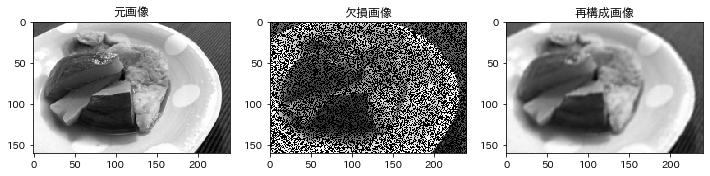

In [8]:
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim

# 結果の表示
plt.figure(figsize=(12, 4))
plt.subplot(1,3,1)
plt.imshow(img, cmap='gray')
plt.title("元画像")
plt.subplot(1,3,2)
plt.imshow(deficit_img, cmap='gray')
plt.title("欠損画像")
plt.subplot(1,3,3)
plt.imshow(reconstructed_img, cmap='gray')
plt.title("再構成画像")
plt.savefig("./img/result/inpainting.png")


print("PSNR:", compare_psnr(img, reconstructed_img))
print("SSIM:", compare_ssim(img, reconstructed_img))

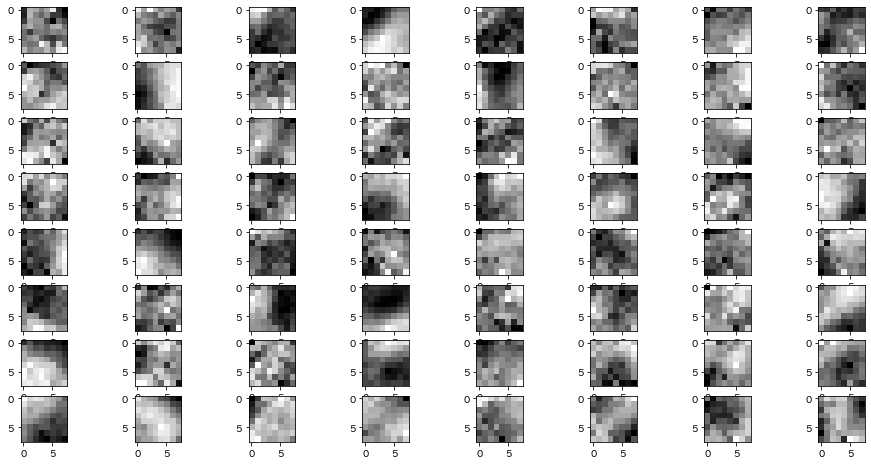

In [9]:
# 学習して得られた辞書の表示
plt.figure(figsize=(16, 8))
for i, base in enumerate(D):
    plt.subplot(8, 8, i + 1)
    plt.imshow(base.reshape(patch_size), 'gray')
plt.savefig("./img/result/image_dictionary.png")